# Modelo VEC vs Modelo MCO

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
from Codigo import *
import seaborn as sn
from statsmodels.stats.diagnostic import normal_ad
sn.set(style="whitegrid")

- Este modelo intenta estimar los datos de el credito al sector privado a traves del nivel de ahorro interno bruto y las reservas legales, obviamente estos dos valores tienen cierto sentido entre ellos y de igual forma afectan al nivel de crédito en la economia.
    - El aumento de los recursos destinandos al prestamo reduciria las tasas de interes aumentando su demanda tanto en el sector de consumo como en el productivo.

## Cargar Datos

In [2]:
Datos = Tachos('../Alemania_Reducida.csv')

In [3]:
Columnas(Datos,'Desempleo, total')
Columnas(Datos,'capital')

Desempleo, total de jóvenes (% de la población activa total entre 15 y 24 años de edad) (estimación modelado OIT)
Desempleo, total de jóvenes (% del total de participación en la fuerza laboral de 15 a 24 años) (estimación nacional)
Desempleo, total (% de participación total en la fuerza laboral) (estimación nacional)
Desempleo, total (% de la población activa total) (estimación modelado OIT)
Ahorro ajustado: consumo de capital fijo (US$ actuales)
Formación bruta de capital (% del crecimiento anual)
Formación bruta de capital fijo (UMN a precios constantes)
Formación bruta de capital fijo (US$ a precios actuales)
Inversiones de cartera, entrada neta de capital (balanza de pagos, US$ a precios actuales)
Formación bruta de capital (US$ a precios constantes de 2010)
Formación bruta de capital fijo (% del crecimiento anual)
Formación bruta de capital fijo, sector privado (% del PIB)
Formación bruta de capital (UMN a precios actuales)
Formación bruta de capital fijo (US$ a precios constantes

In [172]:
data = Datos.copy()
data = data[['Formación bruta de capital (US$ a precios constantes de 2010)','Desempleo, total (% de participación total en la fuerza laboral) (estimación nacional)']]
data.columns = ['inflacion','desempleo']
data.dropna(axis = 0, inplace = True)
print(data.head(10))


            inflacion  desempleo
fecha                           
1983-12-31   3.293415       6.45
1984-12-30   2.405793       6.67
1985-12-31   2.066233       6.88
1986-12-31  -0.129413       6.61
1987-12-31   0.249906       6.81
1988-12-30   1.274119       6.32
1989-12-31   2.780570       5.70
1990-12-31   2.696468       4.89
1991-12-31   4.047033       5.32
1992-12-30   5.056978       6.32


In [173]:
data.index = pd.date_range(start = '1983-12-31', periods= len(data), freq = 'Y')

In [174]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 1983-12-31 to 2022-12-31
Freq: A-DEC
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   inflacion  40 non-null     float64
 1   desempleo  40 non-null     float64
dtypes: float64(2)
memory usage: 960.0 bytes
None


In [175]:
data = data[['desempleo','inflacion']]

### Analisis de Estacionariedad a las Variables

In [176]:
DFuller(datos = data['desempleo'])
print('---------------------------')
DFuller(data['inflacion'])
print('===========================')
print('     RESULTADO       ')
print('===========================')
print('Los resultados indican que los valores no son estacionarios en ninguno de los 3 casos dando valores altisimos')


Estadístico ADF: -0.6435344099856053
Valor p: 0.8608385593242502
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
---------------------------
Estadístico ADF: -2.2278160576883494
Valor p: 0.19630514758095247
No podemos rechazar la hipótesis nula; la serie no es estacionaria.
     RESULTADO       
Los resultados indican que los valores no son estacionarios en ninguno de los 3 casos dando valores altisimos


### Analisis de Cointegración

In [177]:

lag_order = select_order(data, maxlags= 5, deterministic= 'co', seasons= 0)

print(lag_order)
print('Selecionamos el que entre ellos tenga mas repetición y sea el menor por parsimonia')

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 2, BIC -> 1, FPE -> 2, HQIC ->  1>
Selecionamos el que entre ellos tenga mas repetición y sea el menor por parsimonia


In [178]:
print('Al 99% de confianza')
Johansen_Test(data,-1,2,1)

Al 99% de confianza
Matriz de Valores Criticos vs Maximo Valor Propio
            cvm     eigv        Hipotesis
r = 0     2.9762    5.155    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     4.1296    0.1256    No hay suficiente evidencia para rechazar la hipótesis nula de r = 1.
Tabla de Valores Criticos vs Traza Estadistica
            cvt     TS          Hipotesis
r = 0     2.9762    5.2807    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     4.1296    0.1256    No hay suficiente evidencia para rechazar la hipótesis nula de r = 1.


## Modelo Inicial VEC

Para seleccionar el orden el sistema nos dice que para aic y hqic es 10 por lo que usaremos ese 

In [179]:
model = VECM(data ,coint_rank= 1, k_ar_diff= 2, deterministic= 'lo')
result = model.fit()
alpha_matrix = result.alpha
print("Matriz de Coeficientes de Corrección de Errores (alpha):")
print(alpha_matrix)


Matriz de Coeficientes de Corrección de Errores (alpha):
[[-0.02502702]
 [ 0.03888675]]


In [180]:
print(result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation desempleo
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
lin_trend       -0.0110      0.005     -2.348      0.019      -0.020      -0.002
L1.desempleo     0.6339      0.149      4.262      0.000       0.342       0.925
L1.inflacion    -0.0520      0.104     -0.501      0.616      -0.255       0.151
L2.desempleo    -0.3815      0.147     -2.595      0.009      -0.670      -0.093
L2.inflacion    -0.0167      0.112     -0.149      0.882      -0.237       0.203
Det. terms outside the coint. relation & lagged endog. parameters for equation inflacion
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
lin_trend        0.0170      0.009      1.867      0.062      -0.001       0.035
L1.desempleo

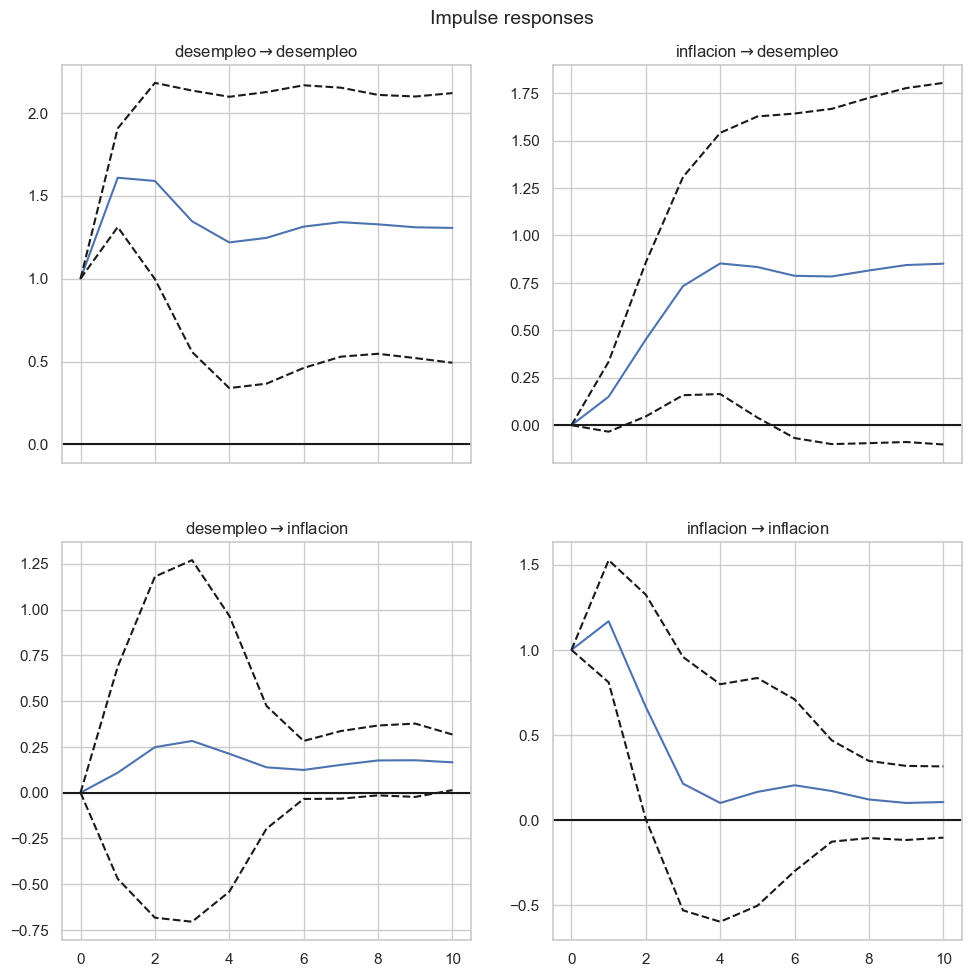

In [181]:
# Paso 6: Análisis de Impulsos-Respuestas
irf = result.irf(periods=10)
irf.plot()
plt.show()

Todos a largo plazo parecen tender al 0 lo que explica que el modelo esta cumpliendo sus propios condicionamientos y no revela un comportamiento caótico, esto es una buena señal de que los parámetros establecidos han sido los adecuados.

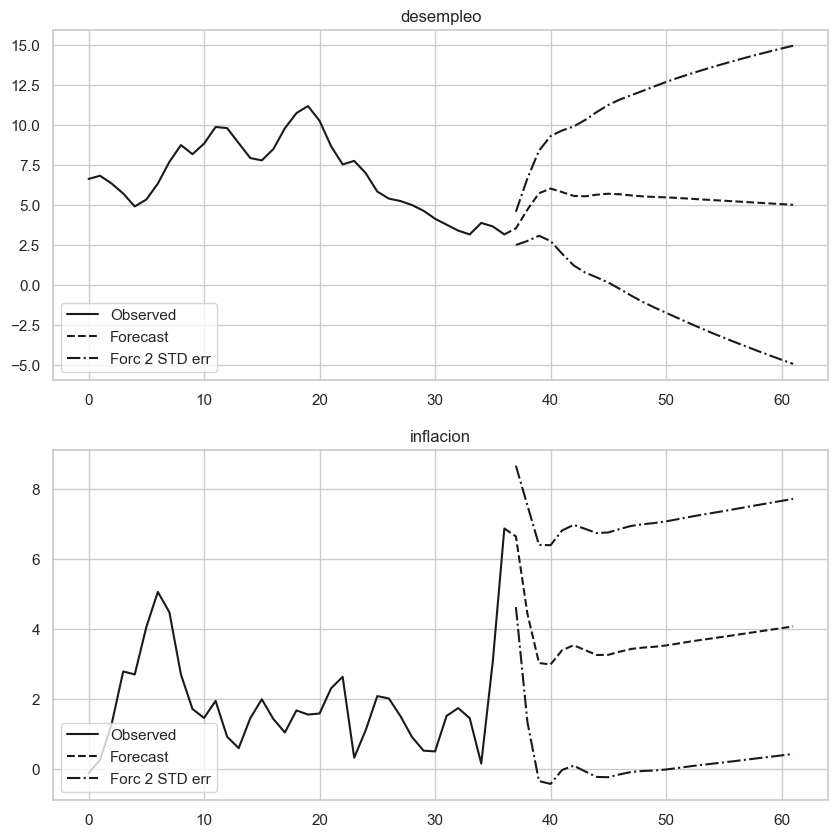

In [182]:
result.plot_forecast(steps = 25)

A pesar de eso la predicción del comportamiento de las reservas y el ahorro interno bruto parecen poco realistas para los proximos años creo que seria bueno agregar otras variables de coyuntura política. Fuera de eso en los primeros 10 años parece tener un comportamiento ciclico que seria interesante revisar

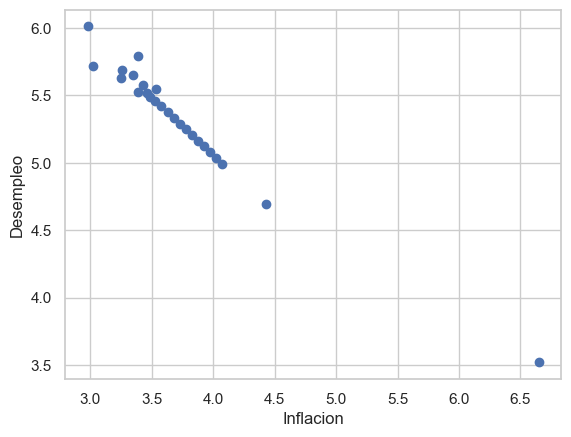

In [192]:
steps = 25
forecast, lower, upper = result.predict(steps, 0.05)
Fecha = pd.date_range(start=data.index[-1], periods=steps, freq='Y')
plt.scatter(forecast[:,1], forecast[:,0])
plt.xlabel('Inflacion')
plt.ylabel('Desempleo')
plt.show()

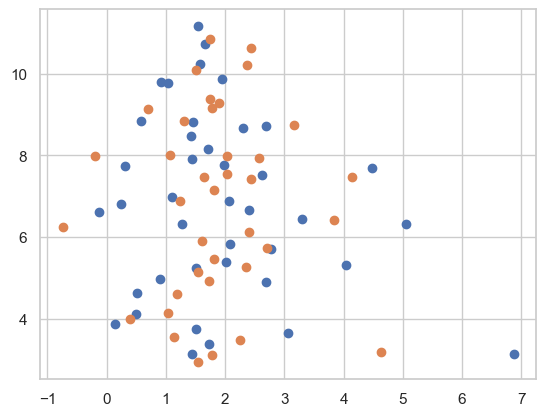

In [193]:
fited = result.fittedvalues
plt.scatter(data['inflacion'],data['desempleo'])
plt.scatter(fited[:,1], fited[:,0])

En este Grafico de la relacion no podemos ver la magnitud de Credito Bancario dado que esta en valores con un maximo de 8e+1 y los otros 1e+12

In [185]:

# Obtén los residuos
residuals = result.resid

# Realiza una prueba de normalidad de los residuos (por ejemplo, prueba Anderson-Darling)
ad_statistic, critical_values = normal_ad(residuals)

# Compara el estadístico con los valores críticos
for i in range(len(ad_statistic)):
    print(f'Anderson-Darling statistic: {ad_statistic[i]}, Critical value: {critical_values[i]}') # type: ignore

    # Compara el estadístico con el valor crítico
    if ad_statistic[i] > critical_values[i]: # type: ignore
        print(f'Se rechaza la hipótesis nula de normalidad para el estadístico {i + 1}.')
    else:
        print(f'No hay suficiente evidencia para rechazar la hipótesis nula de normalidad para el estadístico {i + 1}.')

Anderson-Darling statistic: 0.1784011932030154, Critical value: 0.9122491516010353
No hay suficiente evidencia para rechazar la hipótesis nula de normalidad para el estadístico 1.
Anderson-Darling statistic: 0.9923163427840365, Critical value: 0.011373696990351422
Se rechaza la hipótesis nula de normalidad para el estadístico 2.


Ahora sobre la normalidad de los residuos en los 3 casos dio que ninguna sigue el patron de datos especificado que en este caso es normal por lo que concluimos que los residuos no siguen una distribucion normal.

## MCO

Usaremos linlog dado que los datos independientes son bastante grandes y me parece el normalizador adecuado para este.

In [186]:
import statsmodels.api as sm

In [187]:
y = data['desempleo']
x = data['inflacion']

model = sm.OLS(y,x).fit(cov_type='HC3')
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              desempleo   R-squared (uncentered):                   0.549
Model:                            OLS   Adj. R-squared (uncentered):              0.537
Method:                 Least Squares   F-statistic:                              17.89
Date:                Tue, 19 Dec 2023   Prob (F-statistic):                    0.000137
Time:                        14:58:34   Log-Likelihood:                         -119.49
No. Observations:                  40   AIC:                                      241.0
Df Residuals:                      39   BIC:                                      242.7
Df Model:                           1                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

Manteniendo Constante el Ahorro Interno Bruto cuando las Reservas crecen en una unidad crea un efecto porcentual 430.95% de este en Y, pero cuando mantengo constante las reservas el Ahorro interno bruto crea una disminucion del 419% del valor, lo que me da a entender que pueden estar inversamente correlacionadas y por lo tanto afectado al modelo por ambos lados

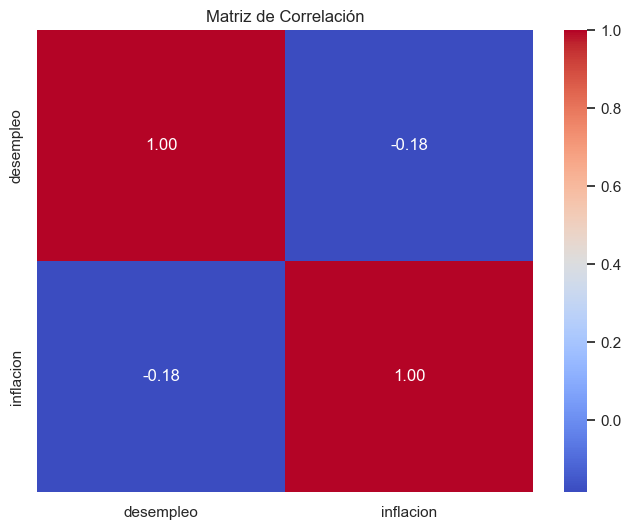

In [188]:

correlation_matrix = data.corr()
plt.figure(figsize=(8, 6))
sn.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


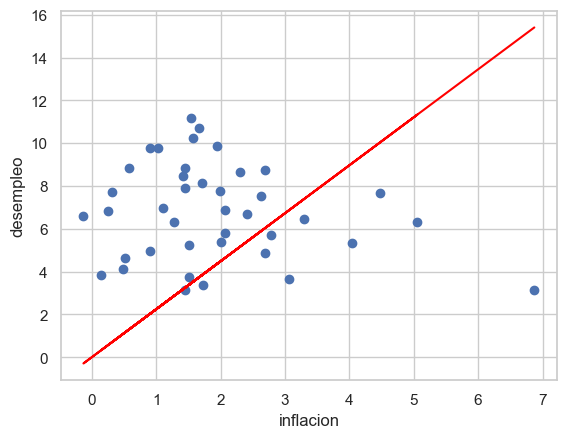

In [189]:
plt.plot(data['inflacion'],model.fittedvalues, label = 'prediccion', color = 'red')
plt.scatter(data['inflacion'],data['desempleo'], label = 'datos')
plt.xlabel('inflacion')
plt.ylabel('desempleo')
plt.show()

- El analisis es mas congruente en el MCO que en el modelo VEC como podemos apreciar pero los datos no se ajustan a los reales en el MCO por otro lado el VEC tiene modelos mas ajustados.